In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pytextrank
import nltk
import os
import sys


current_dir = os.getcwd()
scripts_path = os.path.join(current_dir, 'scripts')

if os.path.basename(current_dir) == 'notebooks':
    project_root = os.path.dirname(current_dir)
    scripts_path = os.path.join(project_root, 'scripts')

if scripts_path not in sys.path:
    sys.path.append(scripts_path)
    print(f"Appended scripts directory to path: {scripts_path}")

try:
    from config import DATA_PATHS
except ImportError as e:
    print(f" Failed to import config.py. Check the path and file name. Error: {e}")

/home/marshy/FOSS/repos/tenx/w2/Analytics-for-fintech-apps/.venv/lib/python3.13/site-packages
Appended scripts directory to path: /home/marshy/FOSS/repos/tenx/w2/Analytics-for-fintech-apps/src/scripts


#### TextBlob is a Python library for Natural Language Processing (NLP).
#### It can do sentiment analysis, part-of-speech tagging, noun phrase extraction, translation, and more.

In [2]:
import pandas as pd

data = pd.read_csv(f"../{DATA_PATHS['raw_reviews']}", index_col=0)  # index_col=0 ignores Unnamed:0
print(data.head())
print(data.columns)

                                                                            review_text  \
review_id                                                                                 
68d8daea-db47-4e23-a692-755173dea983                   maaliif daddafee install gaafata   
ee0dbb0e-4eb0-47b5-9874-c37877493f99                                           good app   
5112423d-e618-44ba-ba49-62677cb76cd6  This application is very important and advanta...   
bcb34681-1dd4-4781-b400-4393bb10b1d9                          why didn't work this app?   
c69f051a-00f8-4144-8423-b7ebcd328d2d      The app makes our life easier. Thank you CBE!   

                                      rating          review_date  \
review_id                                                           
68d8daea-db47-4e23-a692-755173dea983       3  2025-11-28 13:36:32   
ee0dbb0e-4eb0-47b5-9874-c37877493f99       5  2025-11-28 11:33:17   
5112423d-e618-44ba-ba49-62677cb76cd6       5  2025-11-27 23:08:20   
bcb34681-1dd4-478

In [3]:
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 68d8daea-db47-4e23-a692-755173dea983 to 157b5f87-506e-46dc-b89b-179653dbd957
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review_text    1200 non-null   object
 1   rating         1200 non-null   int64 
 2   review_date    1200 non-null   object
 3   user_name      1200 non-null   object
 4   thumbs_up      1200 non-null   int64 
 5   reply_content  2 non-null      object
 6   bank_code      1200 non-null   object
 7   bank_name      1200 non-null   object
 8   app_id         924 non-null    object
 9   source         1200 non-null   object
dtypes: int64(2), object(8)
memory usage: 103.1+ KB
None
(1200, 10)


In [4]:
print(type(data['review_text']))
print(data['review_text'].head())


<class 'pandas.core.series.Series'>
review_id
68d8daea-db47-4e23-a692-755173dea983                     maaliif daddafee install gaafata
ee0dbb0e-4eb0-47b5-9874-c37877493f99                                             good app
5112423d-e618-44ba-ba49-62677cb76cd6    This application is very important and advanta...
bcb34681-1dd4-4781-b400-4393bb10b1d9                            why didn't work this app?
c69f051a-00f8-4144-8423-b7ebcd328d2d        The app makes our life easier. Thank you CBE!
Name: review_text, dtype: object


In [5]:
# --- 1. Handling Null Values ---

print("\n--- 1. Null Value Check (Before Cleaning) ---")
print(data.isnull().sum())

# We focus on the 'review_text' column since it's used for sentiment analysis.
# Strategy: Drop rows where the 'headline' is null, as we can't analyze empty text.
data.dropna(subset=['review_text'], inplace=True)

print("\n--- Null Value Check (After Cleaning) ---")
print(f"Remaining rows after dropping null review_texts: {data.shape[0]}")


--- 1. Null Value Check (Before Cleaning) ---
review_text         0
rating              0
review_date         0
user_name           0
thumbs_up           0
reply_content    1198
bank_code           0
bank_name           0
app_id            276
source              0
dtype: int64

--- Null Value Check (After Cleaning) ---
Remaining rows after dropping null review_texts: 1200


In [6]:
# --- 3. Duplicate and Consistency Checks ---

# Check for duplicate rows across all columns
duplicate_count = data.duplicated().sum()
print(f"\nTotal duplicate rows found: {duplicate_count}")

if duplicate_count > 0:
    # Drop duplicates, keeping the first instance
    data.drop_duplicates(inplace=True)
    print(f"Rows remaining after dropping duplicates: {data.shape[0]}")

# Ensure the 'headline' column is string type before analysis
data['review_text'] = data['review_text'].astype(str)


Total duplicate rows found: 0


In [7]:
# --- 2. Date Structure and Time Series Preparation  ---

if 'review_date' in data.columns:
    
    # 1. Force conversion using 'ISO8601' format and ensure UTC conversion.
    # Setting utc=True handles the mixed timezone offsets by normalizing all values to UTC 
    # and ensures the resulting column is a proper datetime dtype.
    data['review_date'] = pd.to_datetime(data['review_date'], format='ISO8601', utc=True)
    
    print("\n--- 2. Date Column Structure (After Conversion) ---")
    print(data['review_date'].head())
    print(f"Data type is now: {data['review_date'].dtype}")

    # 2. Set the Index
    # Note: Since utc=True was used, the dates are already in UTC.
    data.set_index('review_date', inplace=True)
    print("\nDataFrame Index is now set to Date (UTC).")
    print(data.head()) 
    
else:
    print("\nWarning: Date column not found. Skipping date conversion.")


--- 2. Date Column Structure (After Conversion) ---
review_id
68d8daea-db47-4e23-a692-755173dea983   2025-11-28 13:36:32+00:00
ee0dbb0e-4eb0-47b5-9874-c37877493f99   2025-11-28 11:33:17+00:00
5112423d-e618-44ba-ba49-62677cb76cd6   2025-11-27 23:08:20+00:00
bcb34681-1dd4-4781-b400-4393bb10b1d9   2025-11-27 22:40:35+00:00
c69f051a-00f8-4144-8423-b7ebcd328d2d   2025-11-27 18:00:06+00:00
Name: review_date, dtype: datetime64[ns, UTC]
Data type is now: datetime64[ns, UTC]

DataFrame Index is now set to Date (UTC).
                                                                 review_text  \
review_date                                                                    
2025-11-28 13:36:32+00:00                   maaliif daddafee install gaafata   
2025-11-28 11:33:17+00:00                                           good app   
2025-11-27 23:08:20+00:00  This application is very important and advanta...   
2025-11-27 22:40:35+00:00                          why didn't work this app?   
2025-

In [9]:
# sample['TextBlob_Sentiment'] = sample['review_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
sample = data.copy()
sample.loc[:, 'TextBlob_Sentiment'] = sample['review_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
def sentiment_category(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

sample['TextBlob_Category'] = sample['TextBlob_Sentiment'].apply(sentiment_category)
print(sample[['review_text','TextBlob_Sentiment','TextBlob_Category']])


                                                                 review_text  \
review_date                                                                    
2025-11-28 13:36:32+00:00                   maaliif daddafee install gaafata   
2025-11-28 11:33:17+00:00                                           good app   
2025-11-27 23:08:20+00:00  This application is very important and advanta...   
2025-11-27 22:40:35+00:00                          why didn't work this app?   
2025-11-27 18:00:06+00:00      The app makes our life easier. Thank you CBE!   
...                                                                      ...   
2025-05-08 11:37:34+00:00                                               nice   
2025-05-08 11:07:07+00:00                         excellent game changer App   
2025-05-03 15:53:37+00:00  I am highly excited by using this application ...   
2025-05-03 09:43:29+00:00             it seems me logging out within minutes   
2025-05-03 08:09:08+00:00  nice app espe

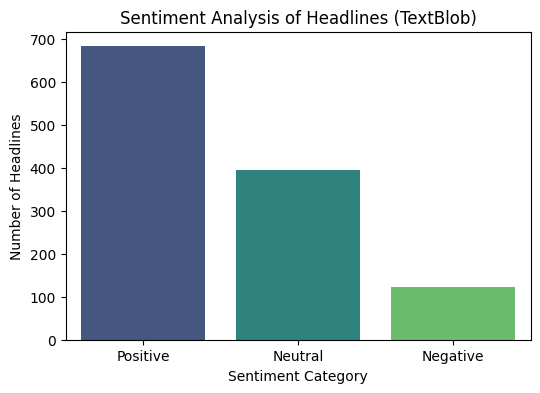

In [10]:
# Count number of headlines in each category
sentiment_counts = sample['TextBlob_Category'].value_counts()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis', legend=False, hue=sentiment_counts.index )
plt.title("Sentiment Analysis of Headlines (TextBlob)")
plt.ylabel("Number of Headlines")
plt.xlabel("Sentiment Category")
plt.show()